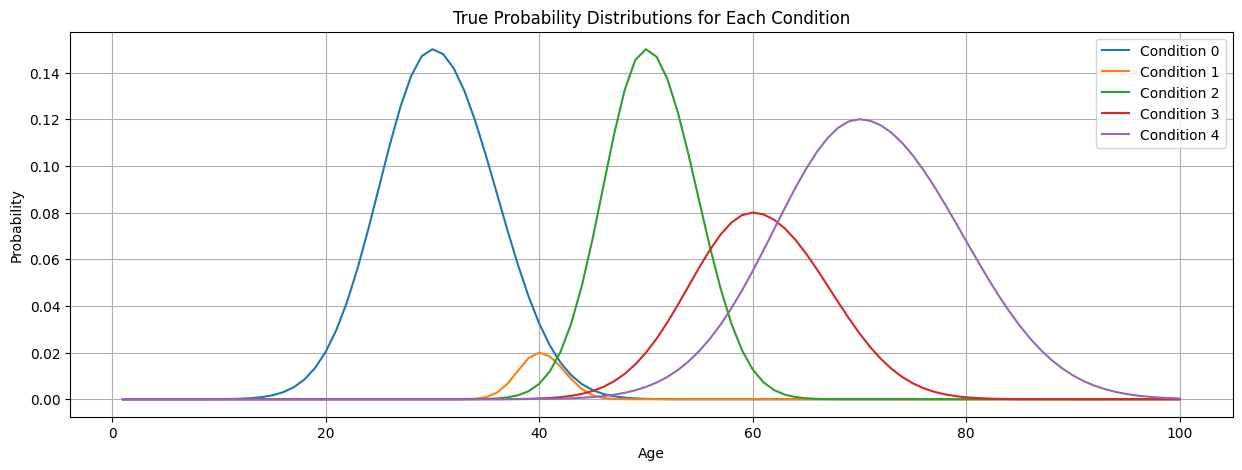

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 5/20:
  Training Loss: 0.7519
  Validation Loss: 0.7091
  Learning Rate: 0.050000

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 10/20:
  Training Loss: 0.7247
  Validation Loss: 0.6962
  Learning Rate: 0.025000

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 15/20:
  Training Loss: 0.7154
  Validation Loss: 0.7010
  Learning Rate: 0.012500

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 20/20:
  Training Loss: 0.7153
  Validation Loss: 0.6975
  Learning Rate: 0.006250



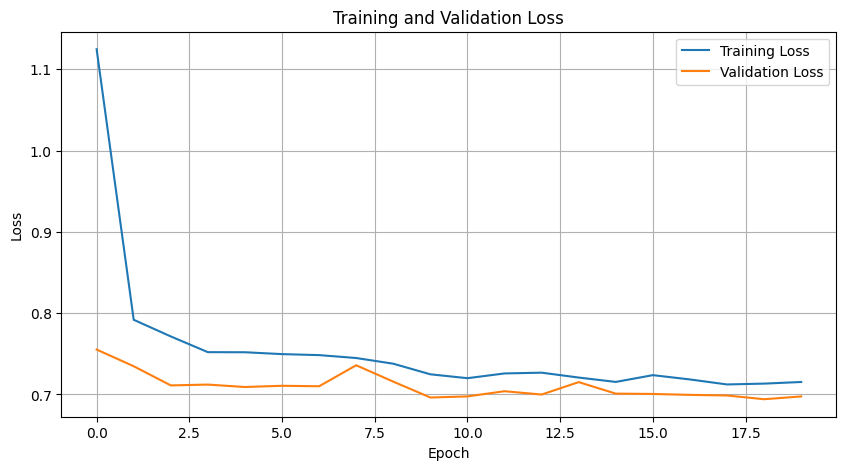

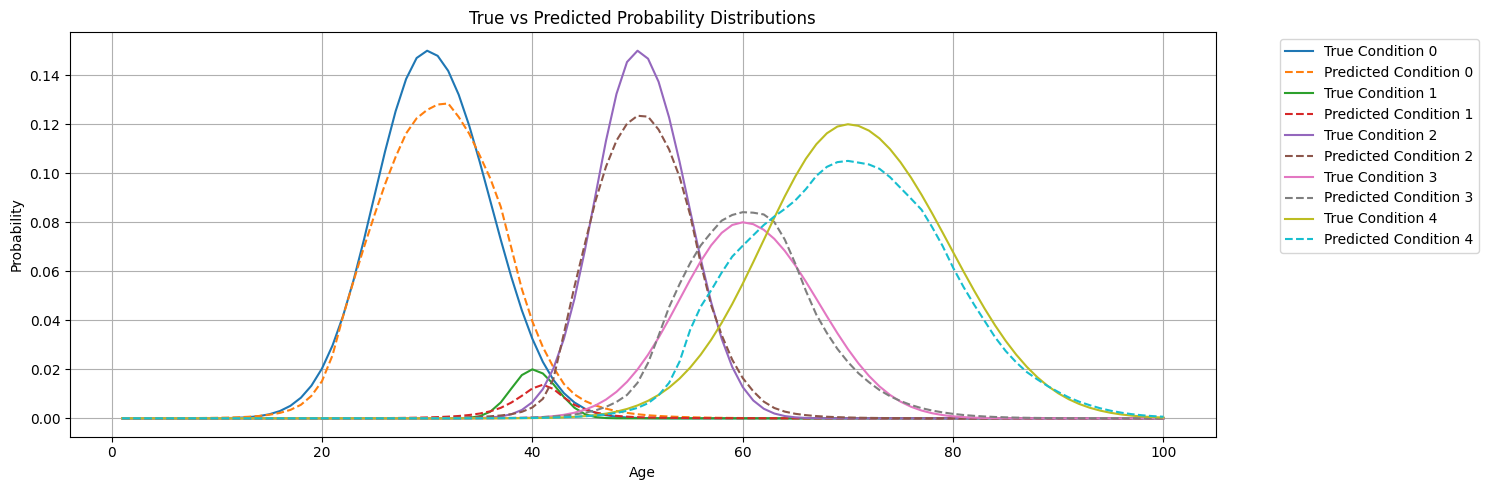


Final test set normalized entropy: 0.6975
Final test set normalized entropy CE: 0.0866
Final test set normalized entropy NE: 0.6975


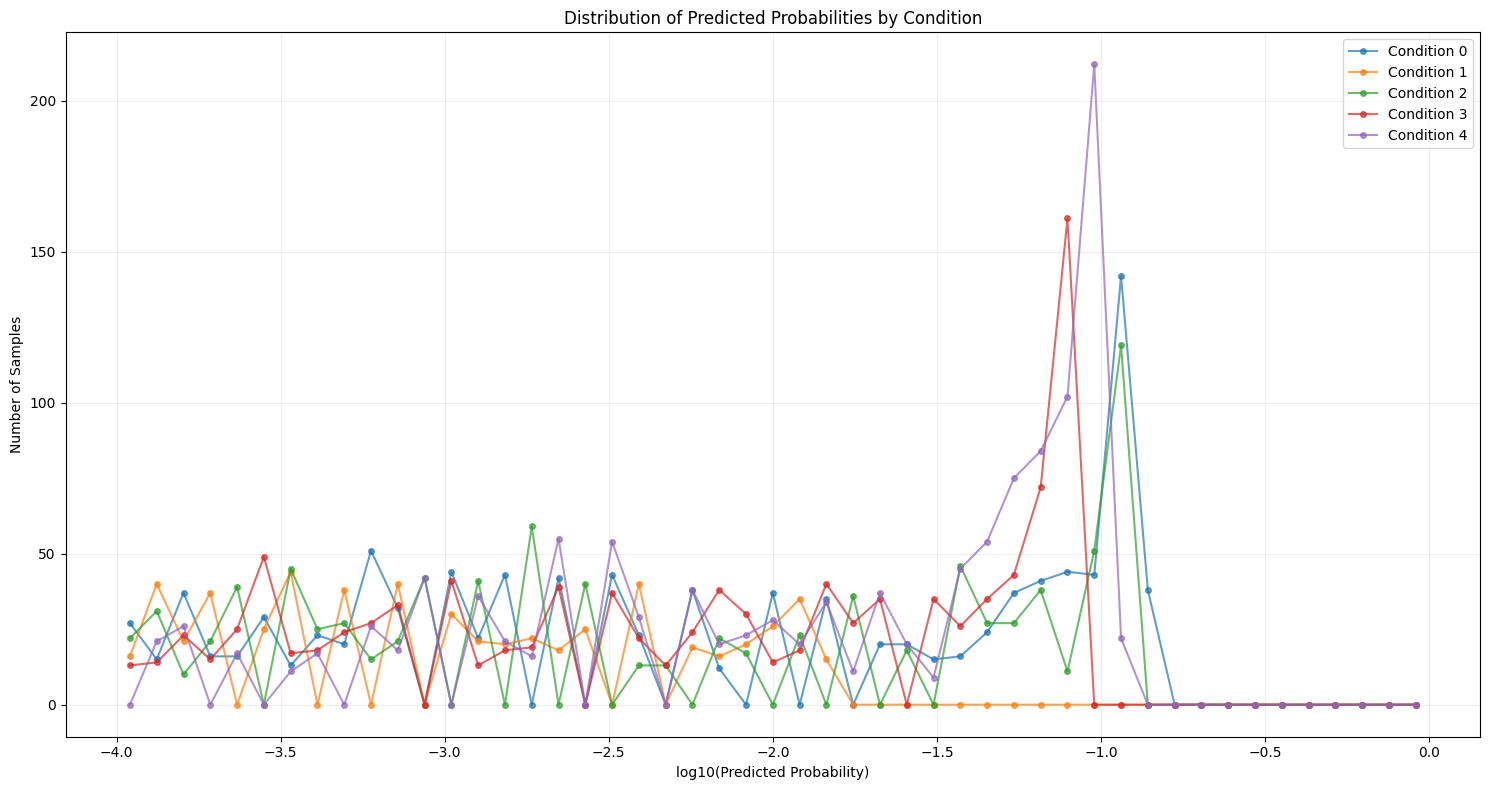

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

def generate_skewed_gaussian(age, mu, std, p_center):
    z = (age - mu) / std
    base_prob = p_center * np.exp(-0.5 * z ** 2)
    if age > mu:
        skew_factor = 1 + 0.15 * (z ** 2)
        base_prob *= skew_factor
    return min(base_prob, 1.0)

class MedicalDataset(Dataset):
    def __init__(self, ages, condition_ids, labels, age_mean, age_std):
        self.ages = torch.FloatTensor((ages - age_mean) / age_std).reshape(-1, 1)
        self.condition_ids = torch.LongTensor(condition_ids)
        self.labels = torch.FloatTensor(labels).reshape(-1, 1)
        
    def __len__(self):
        return len(self.ages)
    
    def __getitem__(self, idx):
        return (self.ages[idx], self.condition_ids[idx]), self.labels[idx]

class ProbabilityNN(nn.Module):
    def __init__(self, num_conditions, embedding_dim, dropout_rate=0.2):
        super().__init__()
        self.condition_embedding = nn.Embedding(num_conditions, embedding_dim)
        input_size = 1 + embedding_dim
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        age, condition_id = x
        condition_emb = self.condition_embedding(condition_id)
        combined_input = torch.cat([age, condition_emb], dim=1)
        return self.network(combined_input)

def normalized_entropy_loss(predictions, labels, reduction='mean'):
    eps = 1e-7
    predictions = torch.clamp(predictions, eps, 1 - eps)
    avg_prediction = (1 + labels.sum()) / labels.numel()
    ce = -labels * torch.log2(predictions) - (1 - labels) * torch.log2(1 - predictions)
    ne_denominator = -labels * torch.log2(avg_prediction) - (1 - labels) * torch.log2(1 - avg_prediction)
    ne = ce.sum() / ne_denominator.sum()
    if reduction == 'mean':
        return ne
    return ne

def normalized_entropy_loss_ce(predictions, labels, reduction='mean'):
    eps = 1e-7
    predictions = torch.clamp(predictions, eps, 1 - eps)
    ce = -labels * torch.log2(predictions) - (1 - labels) * torch.log2(1 - predictions)
    return torch.mean(ce)

def main(mu_list=None, std_list=None, p_center_list=None,
         embedding_dim=8, n_epochs=20, batch_size=1000, train_split=0.9, learning_rate=0.05):
    # Set default parameters if none provided
    if mu_list is None:
        mu_list = [30, 40, 50, 60, 70]
    if std_list is None:
        std_list = [5, 2, 4, 6, 8]
    if p_center_list is None:
        p_center_list = [0.15, 0.02, 0.15, 0.08, 0.12]
    
    # Determine number of conditions from parameter lengths
    K = len(mu_list)
    T = int(100000 / K)
    TOTAL_SAMPLES = T * K

    torch.manual_seed(42)
    np.random.seed(42)

    # Pre-allocate arrays for dataset
    all_ages = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
    all_condition_ids = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
    all_labels = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
    all_true_probs = np.zeros(TOTAL_SAMPLES, dtype=np.float32)

    for condition_id in range(K):
        start_idx = condition_id * T
        end_idx = (condition_id + 1) * T
        ages = np.random.randint(1, 101, size=T)
        probabilities = np.array([
            generate_skewed_gaussian(age, mu_list[condition_id], std_list[condition_id], p_center_list[condition_id])
            for age in ages
        ])
        labels = np.random.binomial(n=1, p=probabilities)
        all_ages[start_idx:end_idx] = ages
        all_condition_ids[start_idx:end_idx] = condition_id
        all_labels[start_idx:end_idx] = labels
        all_true_probs[start_idx:end_idx] = probabilities

    # Normalize ages
    age_mean = np.mean(all_ages)
    age_std = np.std(all_ages)

    # Plot true probability distributions for each condition
    plt.figure(figsize=(15, 5))
    age_range = np.arange(1, 101)
    for condition_id in range(K):
        true_probs = [generate_skewed_gaussian(age, mu_list[condition_id],
                                                 std_list[condition_id],
                                                 p_center_list[condition_id])
                      for age in age_range]
        plt.plot(age_range, true_probs, label=f'Condition {condition_id}')
    plt.xlabel('Age')
    plt.ylabel('Probability')
    plt.title('True Probability Distributions for Each Condition')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare data loaders
    dataset = MedicalDataset(all_ages, all_condition_ids, all_labels, age_mean, age_std)
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model, loss, optimizer, scheduler
    model = ProbabilityNN(num_conditions=K, embedding_dim=embedding_dim)
    criterion = normalized_entropy_loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    plt.figure(figsize=(10, 5))
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_losses = []
        for (age_batch, condition_batch), target_batch in train_loader:
            optimizer.zero_grad()
            output = model((age_batch, condition_batch))
            loss = criterion(output, target_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, ((age_batch, condition_batch), target_batch) in enumerate(test_loader):
                output = model((age_batch, condition_batch))
                batch_loss = criterion(output, target_batch)
                val_loss += batch_loss.item()
                if batch_idx == 0:
                    print('Validation loss components:')
                    _ = criterion(output, target_batch)
        val_loss /= len(test_loader)
        scheduler.step(val_loss)
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}/{n_epochs}:')
            print(f'  Training Loss: {avg_train_loss:.4f}')
            print(f'  Validation Loss: {val_loss:.4f}')
            print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\n')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot predictions vs true probabilities
    plt.figure(figsize=(15, 5))
    age_range_tensor = torch.FloatTensor((np.arange(1, 101) - age_mean) / age_std).reshape(-1, 1)
    model.eval()
    for condition_id in range(K):
        condition_ids = torch.full((100,), condition_id, dtype=torch.long)
        with torch.no_grad():
            predictions = model((age_range_tensor, condition_ids))
        true_probs = [generate_skewed_gaussian(age, mu_list[condition_id],
                                                 std_list[condition_id],
                                                 p_center_list[condition_id])
                      for age in range(1, 101)]
        plt.plot(range(1, 101), true_probs, label=f'True Condition {condition_id}', linestyle='-')
        plt.plot(range(1, 101), predictions.numpy(), label=f'Predicted Condition {condition_id}', linestyle='--')
    plt.xlabel('Age')
    plt.ylabel('Probability')
    plt.title('True vs Predicted Probability Distributions')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute and print final test losses
    model.eval()
    test_loss = 0
    test_loss_ce = 0
    test_loss_ne = 0
    all_predictions = []
    all_condition_ids_plot = []
    with torch.no_grad():
        for (age_batch, condition_batch), target_batch in test_loader:
            output = model((age_batch, condition_batch))
            test_loss += criterion(output, target_batch).item()
            test_loss_ce += normalized_entropy_loss_ce(output, target_batch).item()
            test_loss_ne += normalized_entropy_loss(output, target_batch).item()
            all_predictions.extend(output.numpy().flatten())
            all_condition_ids_plot.extend(condition_batch.numpy().flatten())
    test_loss /= len(test_loader)
    print(f'\nFinal test set normalized entropy: {test_loss:.4f}')
    test_loss_ce /= len(test_loader)
    print(f'Final test set normalized entropy CE: {test_loss_ce:.4f}')
    test_loss_ne /= len(test_loader)
    print(f'Final test set normalized entropy NE: {test_loss_ne:.4f}')

    # Plot distribution of predicted probabilities
    plt.figure(figsize=(15, 8))
    all_predictions = np.array(all_predictions)
    all_condition_ids_plot = np.array(all_condition_ids_plot)
    log_bins = np.logspace(-4, 0, 50)
    for condition_id in range(K):
        condition_mask = all_condition_ids_plot == condition_id
        condition_predictions = all_predictions[condition_mask]
        hist, _ = np.histogram(condition_predictions, bins=log_bins)
        bin_centers = np.sqrt(log_bins[:-1] * log_bins[1:])
        plt.plot(np.log10(bin_centers), hist, label=f'Condition {condition_id}',
                 marker='o', markersize=4, alpha=0.7)
    plt.xlabel('log10(Predicted Probability)')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Predicted Probabilities by Condition')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()